# Test passive membrane properties using neurons with different time constants

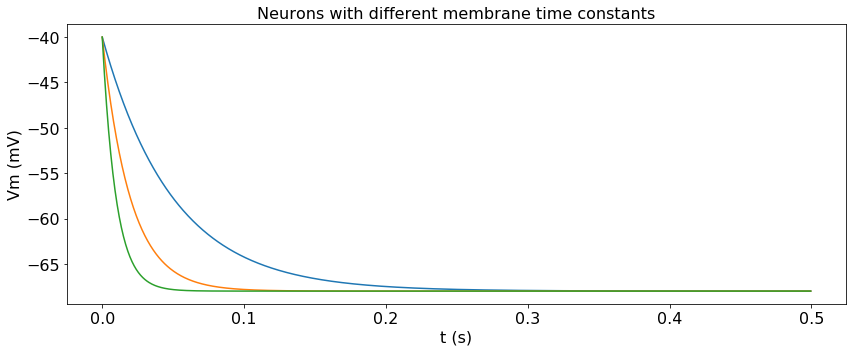

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_leak = -0.068 * np.ones(3)
v_th = -0.036 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002
es_rev = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))

vs_init = -0.04 * np.ones(3)
gs_init = {'AMPA': np.zeros(3)}

ntwk = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_rev=es_rev, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=dt)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants')

set_font_size(ax, 16)

# Extend to case of synaptic-input-induced spiking

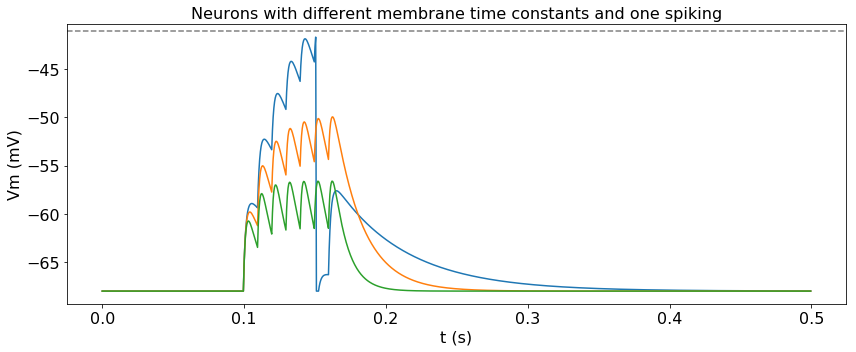

In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_leak = -0.068 * np.ones(3)
v_th = -0.041 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002
es_rev = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': 0.04 * np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))
ts_spks_up = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]

for t in ts_spks_up:
    spks_up[int(t/dt), :] = 1

vs_init = e_leak * np.ones(3)
gs_init = {'AMPA': np.zeros(3)}

ntwk = LIFNtwk(
    t_m=t_m, e_leak=e_leak, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_rev=es_rev, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=dt)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.axhline(-41, color='gray', ls='--')

ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants and one spiking')

set_font_size(ax, 16)